# Prévision de la performance énergétique des bâtiments

<br>

Ecrire un blabla un peu pro
Mettre des titres partout

#### Importation des packages

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#### Importation des données

In [41]:
input_path = 'DataEnergy.csv'
x = pd.read_csv(input_path, sep=",") 
x.head()

,Relative.compactness,Surface.area,Wall.area,Roof.area,Overall.height,orientation,Glazing.area,Glazing.area.distr,Energy,Energy.efficiency
0,0.982928,530.489958,306.484593,112.002683,7.0,North,0.016095,0,34.263943,B
1,0.983547,519.872380,299.776324,110.048028,7.0,East,-0.009387,0,34.589751,B
2,0.979453,516.191221,303.374358,106.408431,7.0,South,-0.000697,0,38.778048,C
3,0.977733,518.924089,292.812213,113.055938,7.0,West,0.000010,0,37.947808,C
4,0.903029,552.968920,316.236102,118.366409,7.0,North,-0.006592,0,47.675859,D


#### Préparation des variables

In [42]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Relative.compactness  768 non-null    float64
 1   Surface.area          768 non-null    float64
 2   Wall.area             768 non-null    float64
 3   Roof.area             768 non-null    float64
 4   Overall.height        768 non-null    float64
 5   orientation           768 non-null    object 
 6   Glazing.area          768 non-null    float64
 7   Glazing.area.distr    768 non-null    int64  
 8   Energy                768 non-null    float64
 9   Energy.efficiency     768 non-null    object 
dtypes: float64(7), int64(1), object(2)
memory usage: 60.1+ KB


In [48]:
# Transformation des variables qualitatives en variables catégorielles

from pandas.api.types import CategoricalDtype

x['Glazing.area.distr']=x['Glazing.area.distr'].astype("category")
x['Glazing.area.distr']=x['Glazing.area.distr'].cat.rename_categories(["Uniform", "55% North", 
                                                                       "55% East", "55% South", 
                                                                       "55% West", 
                                                                       "No glazing"])

cat_type = CategoricalDtype(categories=["A", "B", "C", "D", "E", "F", "G"], ordered=True)
x['Energy.efficiency']=x['Energy.efficiency'].astype(cat_type)

x['orientation']=x['orientation'].astype("category")

x['Overall.height']=x['Overall.height'].astype("category")

<br>

## A. Analyse des données

### 1. Statistiques descriptives univariées

In [56]:
x.describe()

,Relative.compactness,Surface.area,Wall.area,Roof.area,Glazing.area,Energy
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,0.764511,671.349569,318.331811,176.508879,0.234347,46.923575
std,0.105914,88.216217,43.942031,45.206368,0.133144,19.863003
min,0.612496,501.450033,234.338121,105.338876,-0.024009,10.211493
25%,0.677856,598.684672,291.800051,137.385287,0.103055,29.360416
50%,0.751687,673.069405,315.761457,183.308441,0.247521,41.761247
75%,0.835044,744.594128,342.981089,220.510532,0.391185,64.327196
max,0.991210,825.950839,425.805165,225.757721,0.427021,94.842601


On remarque des valeurs négatives pour la variable Glazing Area, qui représente pourtant la surface totale des vitrages. En fait, ces valeurs négatives sont dues à un bruit ajouté. 
Regardons comment sont réparties ces valeurs négatives afin de leur appliquer une correction.

In [72]:
# x[x['Glazing.area']<0]['Glazing.area.distr']

In [91]:
# x[x['Glazing.area.distr']=='Uniform']['Glazing.area'].describe()

In [92]:
# x[x['Glazing.area.distr']=='No glazing']['Glazing.area'].describe()

In [77]:
# A ordonner !!
fig = px.histogram(x, x="Energy.efficiency")
fig.show()

La répartition des données par classe énergie est plutot uniforme. On observe cependant  que la classe A est majoritaire dans ce jeu de données.

In [100]:
fig = px.box(pd.melt(x[['Relative.compactness', 'Surface.area', 'Wall.area', 
                        'Roof.area', 'Glazing.area', 'Energy']]), x="variable", 
             y="value", points="outliers")
fig.show()

Les variables ne sont pas toutes de même ordre de grandeur mais les distributions semblent homogènes. Etant donné les ordres de grandeurs bien différents, une attention particulière sera accordée lors de la réalisation de l'ACP.
Il faut maintenant étudier plus précisemment la répartition des variables mal représentées sur le graphique.

PROF

In [101]:
px.histogram(x, x="Relative.compactness")

In [102]:
px.histogram(x, x="Glazing.area")

Au premier abord, il n'y a pas de transformation de variables nécessaires car les distributions sont "symétriques".

PROF

In [104]:
px.pie(x, names='orientation', title='')

La répartition des orientations des bâtiments est totalement uniforme pour le jeu de données.

In [106]:
px.histogram(x, x="Glazing.area.distr")

La répartition des orientations des vitrages est équitable entre les différentes classes (55% Nord, 55% Est, 55% Sud, 55% Ouest et sans vitrage). Cependant, l'orientation des vitrages de type "uniform" est minoritaire.

<br>

### 2. Statistiques descriptives multivariées

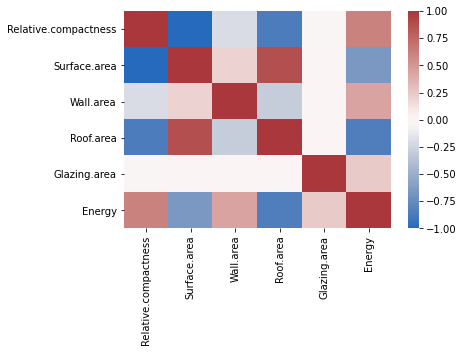

In [113]:
corrMatrix = x.corr()

sns.heatmap(corrMatrix, cmap="vlag", vmin=-1, vmax=1);

Les variables sont globalement très corrélées entre elles.
Relative compactness est très fortement correlé négativement avec Surface area et Roof Area.
Il est difficile de tirer des conclusions avec le graphique des corrélations. Regardons la matrice de scatterplots.

(%A confirmer Une hypothèse serait que les batiments ont la même forme, ainsi seule la surface influe sur cette propriété.

In [140]:
# A retourner en y !

fig = px.scatter_matrix(x, dimensions=['Relative.compactness', 'Surface.area', 'Wall.area', 
                        'Roof.area', 'Glazing.area', 'Energy'])


#fig.update_yaxes(tickangle=)

fig.show()

* On remarque une relation linéaire entre Relative.compactness et Surface.area.
* On observe que Glazing.area, qui est une variable quantitative, est finalement répartie selon 4 intervalles.

In [168]:
## On vérifie la relation Surface.area = Wall.area + 2*Roof.area
a=list(x['Surface.area']-(x['Wall.area']+2*x['Roof.area']))


c=0
for i in range(len(a)):
    if round(a[i], 3) != 0:
        c+=1

print("Nombre de valeurs pour lesquelles la relation \
    Surface.area = Wall.area + 2*Roof.area \
    n est pas vérifiée : ", c)

Nombre de valeurs pour lesquelles la relation     Surface.area = Wall.area + 2*Roof.area     n est pas vérifiée :  0


On peut donc déduire que la surface est calculée en sommant la surface des murs et en ajoutant deux fois la surface du toit.

La relation étant vérifiée pour tous les points de notre jeu de données, nous allons pouvoir supprimer une ou plusieurs variables étant donné que les informations sont redondantes.

Pour continuer l'analyse, on va donc supprimer la surface totale qui regroupe deux informations importantes. On voit en effet sur les plots suivants que ce sont la surface de mur et la surface de toit qui contiennent des informations.

In [174]:
fig = px.box(x, x="Energy.efficiency", y="Wall.area")
fig.show()

In [170]:
fig = px.box(x, x="Energy.efficiency", y="Roof.area")
fig.show()

In [171]:
fig = px.box(x, x="Energy.efficiency", y="Surface.area")
fig.show()

In [89]:
# x.groupby('index')['col'].sum().sort_values(ascending=False).iplot(kind='bar')

In [57]:
print(x['Energy.efficiency'].unique())
print(x['Energy.efficiency'].value_counts(normalize = False))

[B, C, D, E, F, A, G]
Categories (7, object): [A < B < C < D < E < F < G]
A    208
E    109
B    109
F    102
G     81
C     80
D     79
Name: Energy.efficiency, dtype: int64


In [51]:
x['Glazing.area.distr'].value_counts(normalize = False)

No glazing    144
55% West      144
55% South     144
55% East      144
55% North     144
Uniform        48
Name: Glazing.area.distr, dtype: int64

In [58]:
x['Overall.height'].value_counts(normalize = False)

7.0    384
3.5    384
Name: Overall.height, dtype: int64

In [90]:
x['orientation'].value_counts(normalize = False)

West     192
South    192
North    192
East     192
Name: orientation, dtype: int64